<a href="https://colab.research.google.com/github/shubhamscifi/Instacart-Market-Basket-Analysis/blob/main/3.%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Instacart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis/)**

---
- Given order_id predict all the products that the user will reorder.

---








## Kaggle file uploader utility:
- To upload intermediate tables.

In [ ]:
def kaggle_file_uploader(files,id='shubhamscifi/instacart',title='instacart',folder='data',msg='',first_time=False,del_after_upload=True):
    '''Uploads list of files to kaggle.
    Note: make sure to run after kaggle authentication.
    id : must be between 6-50 chars after "username/".
    title : must be between 6-50 chars.
    files : list of path of files that are to be uploaded.
    first_time: True if the data is being uploaded for the first time.
    del_after_upload: True if given folder needs to be deleted after file upload finishes.'''
    # https://github.com/Kaggle/kaggle-api

    # create data package json file
    !mkdir {folder}
    !kaggle datasets init -p {folder}

    # preparing metadata json file
    import json,os
    metadata = open(os.path.join(folder,'dataset-metadata.json'),'r+')
    meta = json.load(metadata)
    meta['id'] = id
    meta['title']= title
    metadata.seek(0)
    json.dump(meta,metadata)
    metadata.truncate()
    metadata.close()

    for file in set(files):
        !cp {file} {folder}

    # upload dataset to kaggle
    if (first_time):
        !kaggle datasets create -p {folder}
    else:
        # Create a New Dataset Version
        !kaggle datasets version -p {folder} -m '{msg}'

    if (del_after_upload):
        !rm -rf {folder}

## Importing libraries

In [ ]:
import plotly
import plotly.express as px
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import gc   # garbage collector
import pickle
# https://pypi.org/project/tqdm/#:~:text=jupyter%20console.%20Use-,auto,-instead%20of%20autonotebook
from tqdm.auto import tqdm
import time
from joblib import Parallel, delayed
from sklearn.metrics import f1_score,confusion_matrix,\
                            precision_recall_fscore_support,classification_report,\
                            accuracy_score,log_loss
from sklearn.model_selection import train_test_split

bold = lambda string: '\033[1m'+string+'\033[0m'    # for bold text
printb = lambda string: print('\033[1m'+string+'\033[0m')
# https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747

## Loading Data

In [ ]:
# loading data into pandas dataframe
orders = pd.read_csv('/content/orders.csv',dtype={'order_id':np.uint32,
                                                  'user_id' :np.uint32,
                                                  'order_number':'uint8',
                                                  'order_hour_of_day':'uint8',
                                                  'order_dow':'uint8',
                                                  'days_since_prior_order':'float16'})
dep = pd.read_csv('/content/departments.csv', dtype={'department_id':'uint8',
                                                     'department': str})
aisles = pd.read_csv('/content/aisles.csv', dtype={'aisle_id':'uint8',
                                                     'aisle': str})
products = pd.read_csv('/content/products.csv', dtype={'aisle_id':'uint8',
                                                     'department_id':'uint8',
                                                     'product_name': str,
                                                     'product_id': np.uint16})
order_products_prior = pd.read_csv('/content/order_products__prior.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})
order_products_train = pd.read_csv('/content/order_products__train.csv',
                                   dtype={'add_to_cart_order':'uint8',
                                          'reordered':'uint8',
                                          'order_id':np.uint32,
                                          'product_id':np.uint16})

## Merging Tables.

In [ ]:
# Merging relational tables
# joining orders and order_products_prior table to get whole prior data table.
prior_data = orders.merge(order_products_prior, how='inner', on='order_id')

# sorting prior_data to get a more structured data so that we can analyse well.
prior_data.sort_values(['user_id','order_number','add_to_cart_order'],inplace=True, axis='index',\
                 ignore_index=True)
prior_data

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered
0,2539329,1,prior,1,2,8,NaN,196,1,0
1,2539329,1,prior,1,2,8,NaN,14084,2,0
2,2539329,1,prior,1,2,8,NaN,12427,3,0
3,2539329,1,prior,1,2,8,NaN,26088,4,0
4,2539329,1,prior,1,2,8,NaN,26405,5,0
...,...,...,...,...,...,...,...,...,...,...
32434484,2977660,206209,prior,13,1,12,7.0,14197,5,1
32434485,2977660,206209,prior,13,1,12,7.0,38730,6,0
32434486,2977660,206209,prior,13,1,12,7.0,31477,7,0
32434487,2977660,206209,prior,13,1,12,7.0,6567,8,0


In [ ]:
prod_info = products.merge(dep,on='department_id').merge(aisles,on='aisle_id')
prod_info

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes
...,...,...,...,...,...,...
49683,22827,Organic Black Mission Figs,18,10,bulk,bulk dried fruits vegetables
49684,28655,Crystallized Ginger Chunks,18,10,bulk,bulk dried fruits vegetables
49685,30365,Vegetable Chips,18,10,bulk,bulk dried fruits vegetables
49686,38007,Naturally Sweet Plantain Chips,18,10,bulk,bulk dried fruits vegetables




---



## **Dataset Preparation**

In [ ]:
# users and their prior order's products
users_prior_order_products = prior_data[['user_id','product_id']]\
                            .drop_duplicates(ignore_index=True)
users_prior_order_products

,user_id,product_id
0,1,196
1,1,14084
2,1,12427
3,1,26088
4,1,26405
...,...,...
13307948,206209,39216
13307949,206209,38730
13307950,206209,31477
13307951,206209,6567


In [ ]:
# users and their prior order's products and future_order_id
users = orders.loc[~orders.eval_set.str.contains('prior'),['user_id','order_id','eval_set']]
dataset = users_prior_order_products.merge(users,on='user_id',how='inner')
del users_prior_order_products
del users
dataset

,user_id,product_id,order_id,eval_set
0,1,196,1187899,train
1,1,14084,1187899,train
2,1,12427,1187899,train
3,1,26088,1187899,train
4,1,26405,1187899,train
...,...,...,...,...
13307948,206209,39216,272231,train
13307949,206209,38730,272231,train
13307950,206209,31477,272231,train
13307951,206209,6567,272231,train


In [ ]:
dataset = dataset.merge(order_products_train,on=['order_id','product_id'],how='left')
dataset.drop(columns=['add_to_cart_order'],inplace=True)
dataset.loc[(dataset['reordered'].isna()) & (dataset.eval_set.str.contains('train')),'reordered']=0
dataset

,user_id,product_id,order_id,eval_set,reordered
0,1,196,1187899,train,1.0
1,1,14084,1187899,train,0.0
2,1,12427,1187899,train,0.0
3,1,26088,1187899,train,1.0
4,1,26405,1187899,train,1.0
...,...,...,...,...,...
13307948,206209,39216,272231,train,1.0
13307949,206209,38730,272231,train,0.0
13307950,206209,31477,272231,train,0.0
13307951,206209,6567,272231,train,0.0


**Train-validation split.**

In [ ]:
users_train = orders.loc[orders.eval_set.str.contains('train'),['user_id']]
users_train, users_cv = train_test_split(users_train,
                                         shuffle=True,
                                         test_size=0.3,
                                         random_state=31)
print(f'No. of train users = {len(users_train)}')
print(f'No. of cv users = {len(users_cv)}')

No. of train users = 91846
No. of cv users = 39363


In [ ]:
users_cv['set']='cv'
users_cv.head()

,user_id,set
36594,2260,cv
77977,4752,cv
1084601,65324,cv
2067224,124271,cv
1676808,100656,cv


In [ ]:
# adding cv to the eval_set for cv users
dataset = dataset.merge(users_cv,on='user_id',how='left')
dataset.loc[dataset['set']=='cv','eval_set']='cv'
dataset.drop(columns=['set'],inplace=True)
dataset

,user_id,product_id,order_id,eval_set,reordered
0,1,196,1187899,cv,1.0
1,1,14084,1187899,cv,0.0
2,1,12427,1187899,cv,0.0
3,1,26088,1187899,cv,1.0
4,1,26405,1187899,cv,1.0
...,...,...,...,...,...
13307948,206209,39216,272231,train,1.0
13307949,206209,38730,272231,train,0.0
13307950,206209,31477,272231,train,0.0
13307951,206209,6567,272231,train,0.0


In [ ]:
print('No. of datapoints in each set:')
print('Train:'.ljust(12),len(dataset[dataset.eval_set=='train']))
print('Validation:'.ljust(12),len(dataset[dataset.eval_set=='cv']))
print('Test:'.ljust(12),len(dataset[dataset.eval_set=='test']))

No. of datapoints in each set:
Train:       5929287
Validation:  2545374
Test:        4833292


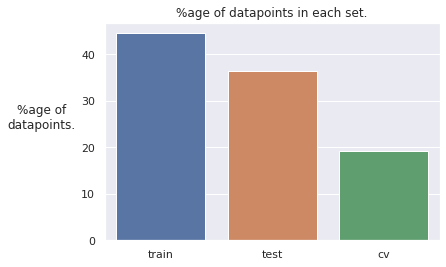

In [ ]:
eval_set_percentage = dataset['eval_set'].value_counts(normalize=True)*100
sns.barplot(x=eval_set_percentage.index,y=eval_set_percentage,orient='v')
plt.ylabel('%age of\ndatapoints.',rotation=0,labelpad=40,)
plt.title('%age of datapoints in each set.');

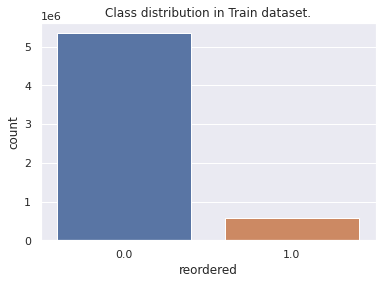

In [ ]:
# class distribution cv
sns.countplot(data=dataset[dataset.eval_set=='train'],x='reordered')
plt.title('Class distribution in Train dataset.');

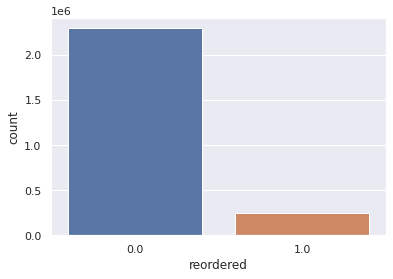

In [ ]:
# class distribution in train
sns.countplot(data=dataset[dataset.eval_set=='cv'],x='reordered');

### Feature Engineering

- user:
    - #reorders
        1. **#reorders_u:** Sum of #reorders of each order of the user.
        2. **mean_#reorders:** Avg. of #reorders of each order by the user.
        3. **median_#reorders:** Median of #reorders of each order by the user.
        4. **min_#reorders:** Min of #reorders of each order by the user.
        5. **max_#reorders:** Max of #reorders of each order by the user.
    - #purchases(or cart_size)
        6. **#purchases_u:** Sum of #purchases of each order by the user.
        7. **mean_#purchases:** Avg of #purchases of each order by the user.
        8. **median_#purchases:** Median of #purchases of each order by the user.
        9. **min_#purchases:** Min of #purchases of each order by the user.
        10. **max_#purchases:** Max of #purchases of each order by the user.
    - #first_purchase
        11. **#first_purchases_u:** Sum of no. of products in each order that has been purchased for the 1st time by the user.
        12. **mean_#first_purchases:** Mean of no. of products in each order that has been purchased for the 1st time by the user.
        13. **median_#first_purchases:** Median of no. of products in each order that has been purchased for the 1st time by the user.
        14. **min_#first_purchases:** Min of no. of products in each order that has been purchased for the 1st time by the user.
        15. **max_#first_purchases:** Max of no. of products in each order that has been purchased for the 1st time by the user.
    - probability
        16. **p(reorder|user):** #reorders_u/#Purchases_u
        17. **mean_p(reorder|user,order):** Mean of (#reorders in each order)/(#purchases in each order).
        18. **median_p(reorder|user,order):** Median of (#reorders in each order)/(#purchases in each order).
        19. **max_p(reorder|user,order):** Max of (#reorders in each order)/(#purchases in each order).
        20. **min_p(reorder|user,order):** Min of (#reorders in each order)/(#purchases in each order).

- product:
    21. **#reorders_p:** No. of times the product has been reordered.
    22. **#purchases_p:** No. of times the product has been purchased.
    23. **#first_purchases_p:** No. of times the product has been purchased for the first time by any user.
    24. **p(reorder|product):** #reorders_p/#purchases_p.
    - Department and aisle
        25. **dep_target_enc:** Target encoding of department: P(reordered=1| department).
        26. **aisle_target_enc:** Target encoding of aisle: P(reordered=1| aisle).
        27. **#avg_reorders_dep:** (Total #reorders from given department) / (Total #products in the department).
        28. **#avg_reorders_aisle:** (Total #reorders from given aisle) / (Total #products in the aisle).
        29. **p(reorder|dep_of_prod):** (Total #reorders from the given department in the past) / (Total #purchases from the department).
        30. **p(reorder|aisle_of_prod):** (Total #reorders from the given aisle in the past) / (Total #purchases from the aisle).
        31. **eatable:** 1 if product belongs to eatable department otherwise 0.

- user_product:
    32. **#reorders_up:** No. of times the user has reordered the given product.
    33. **p(reorder|user,product):** (#orders where given product was rerodered by user)/ (Total #orders by user)
    34. **reordered_in_last_order:** 1 if given user reordered the given product in his last order otherwise 0.
    35. **reordered_in_2ndlast_order:** 1 if given user reordered the given product in his 2nd last order otherwise 0.
    36. **reordered_in_3rdlast_order:** 1 if given user reordered the given product in his 3rd last order otherwise 0.

#### Adding user features:

In [ ]:
user_info = (
    prior_data.groupby('user_id')['reordered']
    .agg(['sum','count'])
    .rename(columns={'sum':'#reorders_u', 'count':'#purchases_u'})
    .reset_index()
)
user_info.head()

,user_id,#reorders_u,#purchases_u
0,1,41.0,59
1,2,93.0,195
2,3,55.0,88
3,4,1.0,18
4,5,14.0,37


In [ ]:
user_info['#first_purchases_u'] = user_info['#purchases_u']-user_info['#reorders_u']
user_info['p(reorder|user)_u'] = user_info['#reorders_u']/user_info['#purchases_u']
user_info.head()

,user_id,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u
0,1,41.0,59,18.0,0.694915
1,2,93.0,195,102.0,0.476923
2,3,55.0,88,33.0,0.625000
3,4,1.0,18,17.0,0.055556
4,5,14.0,37,23.0,0.378378


In [ ]:
user_purchases_per_order = (
    prior_data[prior_data.order_number!=1].groupby(['user_id','order_id'])['reordered']
    .agg(['sum','count'])
    .rename(columns={'sum':'#reorders_u', 'count':'#purchases_u'})
    .reset_index()
)
# not considered order_number=1 because reorders will be 0 for this order.
user_purchases_per_order.head()

,user_id,order_id,#reorders_u,#purchases_u
0,1,431534,5,8
1,1,473747,3,5
2,1,550135,5,5
3,1,2254736,5,5
4,1,2295261,6,6


In [ ]:
user_purchases_per_order['#first_purchases_u'] = user_purchases_per_order['#purchases_u']-user_purchases_per_order['#reorders_u']
user_purchases_per_order['p(reorder|user,order)_u'] = user_purchases_per_order['#reorders_u']/user_purchases_per_order['#purchases_u']
user_purchases_per_order.head()

,user_id,order_id,#reorders_u,#purchases_u,#first_purchases_u,"p(reorder|user,order)_u"
0,1,431534,5,8,3,0.625
1,1,473747,3,5,2,0.600
2,1,550135,5,5,0,1.000
3,1,2254736,5,5,0,1.000
4,1,2295261,6,6,0,1.000


In [ ]:
user_purchases_per_order.drop(columns=['order_id'],inplace=True)

In [ ]:
user_purchases_per_order = (
    user_purchases_per_order
    .groupby('user_id')
    .agg(['mean','median','min','max'])
)
user_purchases_per_order

#reorders_u             ... p(reorder|user,order)_u                    
               mean median min  ...                  median       min       max
user_id                         ...                                            
1          4.555556    5.0   3  ...                0.666667  0.500000  1.000000
2          7.153846    9.0   0  ...                0.571429  0.000000  0.888889
3          5.000000    5.0   1  ...                0.777778  0.200000  1.000000
4          0.250000    0.0   0  ...                0.000000  0.000000  0.142857
5          4.666667    4.0   2  ...                0.444444  0.400000  0.666667
...             ...    ...  ..  ...                     ...       ...       ...
206205     4.000000    4.0   2  ...                0.553571  0.250000  0.857143
206206     2.045455    2.0   0  ...                0.500000  0.000000  1.000000
206207     8.733333    8.0   1  ...                0.666667  0.200000  1.000000
206208     9.979167    9.0   2  ...                0.750000  0.285714  1.000000
206209     5.083333    4.0   1  ...                0.516667  0.250000  1.000000

[206209 rows x 16 columns]

In [ ]:
user_purchases_per_order.columns = ['_'.join(col[::-1]) for col in user_purchases_per_order.columns]

In [ ]:
user_info = user_info.merge(user_purchases_per_order, on='user_id')
del user_purchases_per_order
user_info

,user_id,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u"
0,1,41.0,59,18.0,0.694915,4.555556,5.0,3,6,6.000000,6.0,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.500000,1.000000
1,2,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.000000,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.000000,0.888889
2,3,55.0,88,33.0,0.625000,5.000000,5.0,1,7,7.090909,6.0,5,11,2.090909,2.0,0,6,0.718710,0.777778,0.200000,1.000000
3,4,1.0,18,17.0,0.055556,0.250000,0.0,0,1,3.500000,2.5,2,7,3.250000,2.5,2,6,0.035714,0.000000,0.000000,0.142857
4,5,14.0,37,23.0,0.378378,4.666667,4.0,2,8,8.666667,9.0,5,12,4.000000,4.0,3,5,0.503704,0.444444,0.400000,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206204,206205,8.0,32,24.0,0.250000,4.000000,4.0,2,6,7.500000,7.5,7,8,3.500000,3.5,1,6,0.553571,0.553571,0.250000,0.857143
206205,206206,135.0,285,150.0,0.473684,2.045455,2.0,0,6,4.257576,4.0,1,24,2.212121,1.0,0,23,0.579323,0.500000,0.000000,1.000000
206206,206207,131.0,223,92.0,0.587444,8.733333,8.0,1,15,13.266667,13.0,5,25,4.533333,4.0,0,14,0.679620,0.666667,0.200000,1.000000
206207,206208,479.0,677,198.0,0.707533,9.979167,9.0,2,26,13.854167,13.5,4,28,3.875000,3.5,0,15,0.714959,0.750000,0.285714,1.000000


#### Adding product features:

In [ ]:
# collection of departments with eatable items
eatables_dep = {"pantry","snacks","frozen","dairy eggs","beverages","meat seafood",
                "deli","bakery","canned goods","alcohol","dry goods pasta",
                "produce","breakfast","international","bulk"}
# Adding eatables columns in prod_info
prod_info['eatable'] = prod_info.apply(lambda row: row['department'] in eatables_dep,axis=1).astype('uint8')

In [ ]:
dep_info = prior_data.merge(prod_info, on='product_id', how='right')\
                .groupby(['department_id','product_id'],as_index=False)\
                ['reordered'].sum()\
                .rename(columns={'reordered':'#reorders'})
dep_info = dep_info.groupby('department_id',as_index=False)\
                    .agg({'#reorders':'mean'})\
                    .rename(columns={'#reorders': '#avg_reorders_dep'})

prod_info = prod_info.merge(dep_info,on='department_id',how='left')
dep_info.head(3)
# #avg_reorders_dep = #reorders from dep / #products in dep

,department_id,#avg_reorders_dep
0,1,302.443224
1,2,27.018248
2,3,487.591029


In [ ]:
dep_info = (
    prior_data.merge(prod_info[['product_id','department_id']],on='product_id')\
                .groupby(['department_id'],as_index=False)['reordered'].mean()\
                .rename(columns={'reordered':'p(reorder|dep_of_prod)'})
)
prod_info = prod_info.merge(dep_info,on='department_id',how='left')
dep_info.head(3)
# p(reorder|dep_of_prod) = #reorders from dep / #purchases from dep

,department_id,p(reorder|dep_of_prod)
0,1,0.541885
1,2,0.407980
2,3,0.628141


In [ ]:
aisle_info = prior_data.merge(prod_info, on='product_id', how='right')\
                .groupby(['aisle_id','product_id'],as_index=False)\
                ['reordered'].sum()\
                .rename(columns={'reordered':'#reorders'})
aisle_info = aisle_info.groupby('aisle_id',as_index=False)\
                    .agg({'#reorders':'mean'})\
                    .rename(columns={'#reorders': '#avg_reorders_aisle'})
prod_info = prod_info.merge(aisle_info,on='aisle_id',how='left')
aisle_info.head(3)
# #avg_reorders_aisle : #reorders from aisle / #products in aisle

,aisle_id,#avg_reorders_aisle
0,1,293.917808
1,2,148.948339
2,3,328.031250


In [ ]:
aisle_info = (
    prior_data.merge(prod_info[['product_id','aisle_id']],on='product_id')\
                .groupby(['aisle_id'],as_index=False)['reordered'].mean()\
                .rename(columns={'reordered':'p(reorder|aisle_of_prod)'})
)
prod_info = prod_info.merge(aisle_info,on='aisle_id',how='left')
aisle_info.head(3)
# p(reorder|aisle_of_prod) = #reorders from aisle / #purchases from aisle

,aisle_id,p(reorder|aisle_of_prod)
0,1,0.596597
1,2,0.489326
2,3,0.598007


In [ ]:
del aisle_info
del dep_info

In [ ]:
prod_reorder = (
    prior_data.groupby('product_id',as_index=False)
    .agg(**{
        '#reorders_p':('reordered','sum'),
        '#purchases_p': ('reordered','count')})
)
prod_reorder.head()

,product_id,#reorders_p,#purchases_p
0,1,1136.0,1852
1,2,12.0,90
2,3,203.0,277
3,4,147.0,329
4,5,9.0,15


In [ ]:
prod_info = prod_info.merge(prod_reorder, on='product_id', how='left')
del prod_reorder
# filling nan with zero for the products which haven't been ordered once
prod_info.fillna(value=0,inplace=True)
prod_info['#first_purchases_p'] = prod_info['#purchases_p'] - prod_info['#reorders_p']
prod_info['p(reorder|product)_p'] = (
    prod_info.apply(lambda row: row['#reorders_p']/row['#purchases_p'] 
                                if (row['#purchases_p']!=0)
                                else 0,axis=1)
)
prod_info.head()

,product_id,product_name,aisle_id,department_id,department,aisle,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p
0,1,Chocolate Sandwich Cookies,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,1136.0,1852.0,716.0,0.613391
1,78,Nutter Butter Cookie Bites Go-Pak,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,3.0,11.0,8.0,0.272727
2,102,Danish Butter Cookies,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,35.0,185.0,150.0,0.189189
3,172,Gluten Free All Natural Chocolate Chip Cookies,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,71.0,97.0,26.0,0.731959
4,285,Mini Nilla Wafers Munch Pack,61,19,snacks,cookies cakes,1,264.682791,0.57418,146.946224,0.548698,56.0,156.0,100.0,0.358974


#### Adding user-product features:

In [ ]:
user_prod = (prior_data
            .groupby(['user_id','product_id'],
                     as_index=False)['reordered']
             .sum()
             .rename(columns={'reordered':'#reorders_up'})
)
user_prod

,user_id,product_id,#reorders_up
0,1,196,9
1,1,10258,8
2,1,10326,0
3,1,12427,9
4,1,13032,2
...,...,...,...
13307948,206209,43961,2
13307949,206209,44325,0
13307950,206209,48370,0
13307951,206209,48697,0


In [ ]:
user_prod = user_prod.merge(prior_data.groupby(['user_id'],as_index=False)
                            ['order_number'].max()
                            .rename(columns={'order_number':'#orders'}),
                            on='user_id')
user_prod

,user_id,product_id,#reorders_up,#orders
0,1,196,9,10
1,1,10258,8,10
2,1,10326,0,10
3,1,12427,9,10
4,1,13032,2,10
...,...,...,...,...
13307948,206209,43961,2,13
13307949,206209,44325,0,13
13307950,206209,48370,0,13
13307951,206209,48697,0,13


In [ ]:
user_prod['p(reorder|user,product)_up'] = (
    user_prod['#reorders_up']/(user_prod['#orders'] -1)
)
user_prod.drop(columns=['#orders'],inplace=True)
user_prod

,user_id,product_id,#reorders_up,"p(reorder|user,product)_up"
0,1,196,9,1.000000
1,1,10258,8,0.888889
2,1,10326,0,0.000000
3,1,12427,9,1.000000
4,1,13032,2,0.222222
...,...,...,...,...
13307948,206209,43961,2,0.166667
13307949,206209,44325,0,0.000000
13307950,206209,48370,0,0.000000
13307951,206209,48697,0,0.000000


In [ ]:
def get_products(df):
    '''Returns DataFrame of reordered products of last order.'''
    max_order_num = df.order_number.max()
    return df.loc[(df.order_number==max_order_num) & (df.reordered==1),['product_id']]

user_last_order_prod = prior_data.groupby('user_id').apply(lambda df: get_products(df))
user_last_order_prod = user_last_order_prod.droplevel(level=1)
user_last_order_prod.reset_index(inplace=True)
user_last_order_prod['reordered_in_last_order'] = 1
user_last_order_prod

,user_id,product_id,reordered_in_last_order
0,1,196,1
1,1,46149,1
2,1,25133,1
3,1,10258,1
4,1,13032,1
...,...,...,...
1254588,206208,10385,1
1254589,206209,24852,1
1254590,206209,9405,1
1254591,206209,16168,1


In [ ]:
user_prod = user_prod.merge(user_last_order_prod, on=['user_id','product_id'],how='left')
del user_last_order_prod
user_prod['reordered_in_last_order'].fillna(0,inplace=True)
user_prod['reordered_in_last_order'] = user_prod['reordered_in_last_order'].astype('uint8')
user_prod

,user_id,product_id,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order
0,1,196,9,1.000000,1
1,1,10258,8,0.888889,1
2,1,10326,0,0.000000,0
3,1,12427,9,1.000000,1
4,1,13032,2,0.222222,1
...,...,...,...,...,...
13307948,206209,43961,2,0.166667,0
13307949,206209,44325,0,0.000000,0
13307950,206209,48370,0,0.000000,0
13307951,206209,48697,0,0.000000,0


In [ ]:
def get_products(df):
    '''Returns DataFrame of reordered products of 2nd last order.'''
    second_last_order_num = df.order_number.max()-1
    return df.loc[(df.order_number==second_last_order_num) & (df.reordered==1),['product_id']]

user_2ndlast_order_prod = prior_data.groupby('user_id').apply(lambda df: get_products(df))
user_2ndlast_order_prod = user_2ndlast_order_prod.droplevel(level=1)
user_2ndlast_order_prod.reset_index(inplace=True)
user_2ndlast_order_prod['reordered_in_2ndlast_order'] = 1
user_2ndlast_order_prod

,user_id,product_id,reordered_in_2ndlast_order
0,1,49235,1
1,1,46149,1
2,1,25133,1
3,1,196,1
4,1,10258,1
...,...,...,...
1188956,206209,23800,1
1188957,206209,13838,1
1188958,206209,48742,1
1188959,206209,23594,1


In [ ]:
user_prod = user_prod.merge(user_2ndlast_order_prod, on=['user_id','product_id'],how='left')
del user_2ndlast_order_prod
user_prod['reordered_in_2ndlast_order'].fillna(0,inplace=True)
user_prod['reordered_in_2ndlast_order'] = user_prod['reordered_in_2ndlast_order'].astype('uint8')
user_prod

,user_id,product_id,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order
0,1,196,9,1.000000,1,1
1,1,10258,8,0.888889,1,1
2,1,10326,0,0.000000,0,0
3,1,12427,9,1.000000,1,1
4,1,13032,2,0.222222,1,0
...,...,...,...,...,...,...
13307948,206209,43961,2,0.166667,0,1
13307949,206209,44325,0,0.000000,0,0
13307950,206209,48370,0,0.000000,0,0
13307951,206209,48697,0,0.000000,0,0


In [ ]:
def get_products(df):
    '''Returns DataFrame of reordered products of 3rd last order.'''
    third_last_order_num = df.order_number.max()-2
    return df.loc[(df.order_number==third_last_order_num) & (df.reordered==1),['product_id']]

user_3rdlast_order_prod = prior_data.groupby('user_id').apply(lambda df: get_products(df))
user_3rdlast_order_prod = user_3rdlast_order_prod.droplevel(level=1)
user_3rdlast_order_prod.reset_index(inplace=True)
user_3rdlast_order_prod['reordered_in_3rdlast_order'] = 1
user_3rdlast_order_prod

,user_id,product_id,reordered_in_3rdlast_order
0,1,12427,1
1,1,196,1
2,1,10258,1
3,1,25133,1
4,2,32792,1
...,...,...,...
1073754,206209,9405,1
1073755,206209,41213,1
1073756,206209,24852,1
1073757,206209,19348,1


In [ ]:
user_prod = user_prod.merge(user_3rdlast_order_prod, on=['user_id','product_id'],how='left')
del user_3rdlast_order_prod
user_prod['reordered_in_3rdlast_order'].fillna(0,inplace=True)
user_prod['reordered_in_3rdlast_order'] = user_prod['reordered_in_3rdlast_order'].astype('uint8')
user_prod

,user_id,product_id,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order
0,1,196,9,1.000000,1,1,1
1,1,10258,8,0.888889,1,1,1
2,1,10326,0,0.000000,0,0,0
3,1,12427,9,1.000000,1,1,1
4,1,13032,2,0.222222,1,0,0
...,...,...,...,...,...,...,...
13307948,206209,43961,2,0.166667,0,1,0
13307949,206209,44325,0,0.000000,0,0,0
13307950,206209,48370,0,0.000000,0,0,0
13307951,206209,48697,0,0.000000,0,0,0


In [ ]:
dataset = dataset.merge(user_info,on='user_id')
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u"
0,1,196,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,5.0,3,6,6.0,6.0,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.5,1.0
1,1,14084,1187899,cv,0.0,41.0,59,18.0,0.694915,4.555556,5.0,3,6,6.0,6.0,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.5,1.0
2,1,12427,1187899,cv,0.0,41.0,59,18.0,0.694915,4.555556,5.0,3,6,6.0,6.0,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.5,1.0


In [ ]:
ftrs = ['product_id','department','aisle','eatable','#avg_reorders_dep',
        'p(reorder|dep_of_prod)','#avg_reorders_aisle','p(reorder|aisle_of_prod)',
        '#reorders_p','#purchases_p','#first_purchases_p','p(reorder|product)_p']
dataset = dataset.merge(prod_info[ftrs],on='product_id')
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",department,aisle,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p
0,1,196,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,5.0,3,6,6.000000,6.0,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.500000,1.000000,beverages,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648
1,15,196,2161313,test,NaN,59.0,72,13.0,0.819444,2.809524,3.0,1,6,3.238095,3.0,1,6,0.428571,0.0,0,3,0.872222,1.000000,0.400000,1.000000,beverages,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648
2,19,196,1735923,test,NaN,71.0,204,133.0,0.348039,8.875000,8.0,2,19,21.500000,23.0,5,42,12.625000,10.0,1,33,0.466648,0.481250,0.190476,0.833333,beverages,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648


In [ ]:
dataset = dataset.merge(user_prod,on=['user_id','product_id'])
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",department,aisle,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order
0,1,196,1187899,cv,1.0,41.0,59,18.0,0.694915,4.555556,5.0,3,6,6.000000,6.0,4,9,1.444444,2.0,0,3,0.784259,0.666667,0.500000,1.000000,beverages,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648,9,1.000000,1,1,1
1,15,196,2161313,test,NaN,59.0,72,13.0,0.819444,2.809524,3.0,1,6,3.238095,3.0,1,6,0.428571,0.0,0,3,0.872222,1.000000,0.400000,1.000000,beverages,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648,4,0.190476,1,1,0
2,19,196,1735923,test,NaN,71.0,204,133.0,0.348039,8.875000,8.0,2,19,21.500000,23.0,5,42,12.625000,10.0,1,33,0.466648,0.481250,0.190476,0.833333,beverages,soft drinks,1,402.724399,0.65346,493.317495,0.638832,27791.0,35791.0,8000.0,0.77648,2,0.250000,0,0,1


In [ ]:
del user_info
del user_prod
prod_info = prod_info[['product_id','product_name','aisle_id','department_id','department','aisle','eatable']]

In [ ]:
gc.collect()

529

In [ ]:
# sorting
dataset.loc[dataset.eval_set=='train','sort']=1
dataset.loc[dataset.eval_set=='cv','sort']=2
dataset.loc[dataset.eval_set=='test','sort']=3
dataset.sort_values(['sort','user_id'],ignore_index=True,inplace=True)
del dataset['sort']
dataset.head(3)

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",department,aisle,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order
0,2,13176,1492625,train,0.0,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.0,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.0,0.888889,produce,fresh fruits,1,3658.378860,0.649913,6846.777487,0.718104,315913.0,379450.0,63537.0,0.832555,0,0.000000,0,0,0
1,2,41787,1492625,train,1.0,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.0,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.0,0.888889,produce,fresh fruits,1,3658.378860,0.649913,6846.777487,0.718104,23015.0,35413.0,12398.0,0.649903,1,0.076923,0,0,0
2,2,32792,1492625,train,1.0,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.0,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.0,0.888889,snacks,popcorn jerky,1,264.682791,0.574180,306.341772,0.591986,791.0,1370.0,579.0,0.577372,8,0.615385,0,0,1


**Target-encoding(Bayesian Encoder) of aisle and department features:**

In [ ]:
# https://contrib.scikit-learn.org/category_encoders/
import category_encoders as ce  # compatible with sklearn pipeline

In [ ]:
#Create target encoding object
# https://contrib.scikit-learn.org/category_encoders/targetencoder.html
encoder=ce.TargetEncoder(cols=['department','aisle'])

#Fit Train Data
encoder.fit(dataset.loc[dataset.eval_set=='train'],dataset.loc[dataset.eval_set=='train','reordered'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



TargetEncoder(cols=['department', 'aisle'], drop_invariant=False,
              handle_missing='value', handle_unknown='value',
              min_samples_leaf=1, return_df=True, smoothing=1.0, verbose=0)

In [ ]:
dataset = encoder.transform(dataset)
dataset = dataset.rename(columns={'department': 'dep_target_enc',
                                  'aisle'     : 'aisle_target_enc'})
dataset.head()

,user_id,product_id,order_id,eval_set,reordered,#reorders_u,#purchases_u,#first_purchases_u,p(reorder|user)_u,mean_#reorders_u,median_#reorders_u,min_#reorders_u,max_#reorders_u,mean_#purchases_u,median_#purchases_u,min_#purchases_u,max_#purchases_u,mean_#first_purchases_u,median_#first_purchases_u,min_#first_purchases_u,max_#first_purchases_u,"mean_p(reorder|user,order)_u","median_p(reorder|user,order)_u","min_p(reorder|user,order)_u","max_p(reorder|user,order)_u",dep_target_enc,aisle_target_enc,eatable,#avg_reorders_dep,p(reorder|dep_of_prod),#avg_reorders_aisle,p(reorder|aisle_of_prod),#reorders_p,#purchases_p,#first_purchases_p,p(reorder|product)_p,#reorders_up,"p(reorder|user,product)_up",reordered_in_last_order,reordered_in_2ndlast_order,reordered_in_3rdlast_order
0,2,13176,1492625,train,0.0,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.0,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,3658.378860,0.649913,6846.777487,0.718104,315913.0,379450.0,63537.0,0.832555,0,0.000000,0,0,0
1,2,41787,1492625,train,1.0,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.0,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,3658.378860,0.649913,6846.777487,0.718104,23015.0,35413.0,12398.0,0.649903,1,0.076923,0,0,0
2,2,32792,1492625,train,1.0,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.0,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.0,0.888889,0.088779,0.098166,1,264.682791,0.574180,306.341772,0.591986,791.0,1370.0,579.0,0.577372,8,0.615385,0,0,1
3,2,47766,1492625,train,0.0,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.0,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.0,0.888889,0.128464,0.169311,1,3658.378860,0.649913,6846.777487,0.718104,134044.0,176815.0,42771.0,0.758103,3,0.230769,0,0,0
4,2,20574,1492625,train,0.0,93.0,195,102.0,0.476923,7.153846,9.0,0,14,14.0,14.0,5,26,6.846154,7.0,1,12,0.482419,0.571429,0.0,0.888889,0.104139,0.104603,1,483.255673,0.607719,642.501340,0.606517,7622.0,10195.0,2573.0,0.747621,1,0.076923,0,0,0


In [ ]:
# Reducing space taken by dataframe
dataset = dataset.astype(dtype={'user_id' : np.uint32,
                                'product_id': np.uint16,
                                'order_id' : np.uint32,
                                'eval_set' : 'category',
                                'reordered': np.float16,
                                'reordered_in_last_order': np.uint8,
                                'reordered_in_2ndlast_order': np.uint8,
                                'reordered_in_3rdlast_order': np.uint8})

In [ ]:
dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 41 columns):
 #   Column                          Dtype   
---  ------                          -----   
 0   user_id                         uint32  
 1   product_id                      uint16  
 2   order_id                        uint32  
 3   eval_set                        category
 4   reordered                       float16 
 5   #reorders_u                     float64 
 6   #purchases_u                    int64   
 7   #first_purchases_u              float64 
 8   p(reorder|user)_u               float64 
 9   mean_#reorders_u                float64 
 10  median_#reorders_u              float64 
 11  min_#reorders_u                 uint8   
 12  max_#reorders_u                 uint8   
 13  mean_#purchases_u               float64 
 14  median_#purchases_u             float64 
 15  min_#purchases_u                int64   
 16  max_#purchases_u                int64   
 17  mean_#

In [ ]:
%%time
# Saving dataset locally
dataset.to_feather('dataset.feather')

CPU times: user 8.96 s, sys: 1.46 s, total: 10.4 s
Wall time: 4.09 s


In [ ]:
# uploading dataset to kaggle.
kaggle_file_uploader(files = ['/content/dataset.feather'],
                     folder='data',
                     id = 'shubhamscifi/instacart',
                     title = 'instacart',
                     msg='demo',
                     first_time=False,
                     del_after_upload=True)

Data package template written to: data/dataset-metadata.json
Starting upload for file dataset.feather
100% 0.99G/0.99G [00:10<00:00, 106MB/s]
Upload successful: dataset.feather (1009MB)
Starting upload for file dataset-prev.feather
100% 603M/603M [00:06<00:00, 96.1MB/s]
Upload successful: dataset-prev.feather (603MB)
Dataset version is being created. Please check progress at /api/v1/datasets/status/shubhamscifi/instacart




---


